# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

34.760764601491935

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

20.231272337560075

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [5]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [6]:
from sklearn.tree import DecisionTreeRegressor
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)

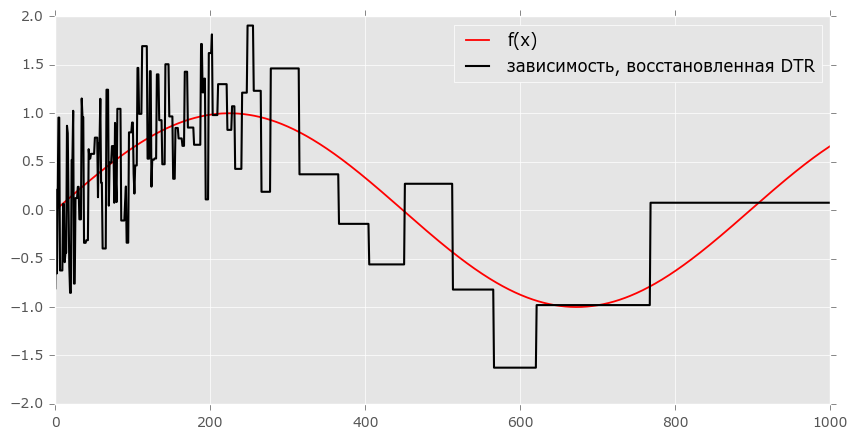

In [7]:
#1
x = np.random.exponential(size=sample_size)

#2
noise = np.random.uniform(-1, 1, size=sample_size)
y = f(x) + noise

#3
DTR = DecisionTreeRegressor()
DTR.fit(x.reshape(-1, 1), y)
predict = DTR.predict(linspace.reshape(-1, 1))

#4
plt.figure(figsize=(10, 5))
plt.plot(f(linspace), c='red', lw=1.3)
plt.plot(predict, c='black', lw=1.5)
plt.legend(['f(x)', 'зависимость, восстановленная DTR'])
plt.show()

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

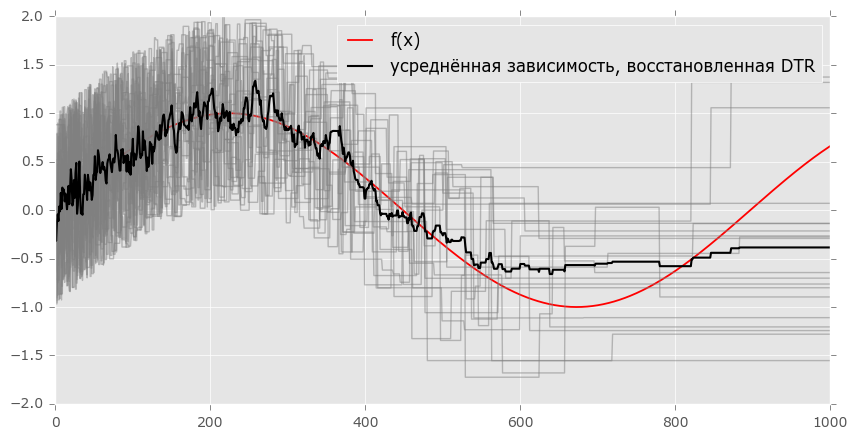

In [8]:
plt.figure(figsize=(10, 5))
p1, = plt.plot(f(linspace), c='red', lw=1.3)

predict_s = []
for i in range(samples_num):
    x = np.random.exponential(size = sample_size)
    noise = np.random.uniform(-1, 1, size = sample_size)
    y = f(x) + noise   
    DTR.fit(x.reshape(-1, 1), y)
    predict = DTR.predict(linspace.reshape(-1, 1))
    plt.plot(predict, color='grey', alpha=0.5)
    predict_s.append(predict)
    
p2, = plt.plot(np.mean(np.array(predict_s), axis=0), c='black', lw=1.5)
plt.legend([p1, p2], ['f(x)', 'усреднённая зависимость, восстановленная DTR'])
plt.show()

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

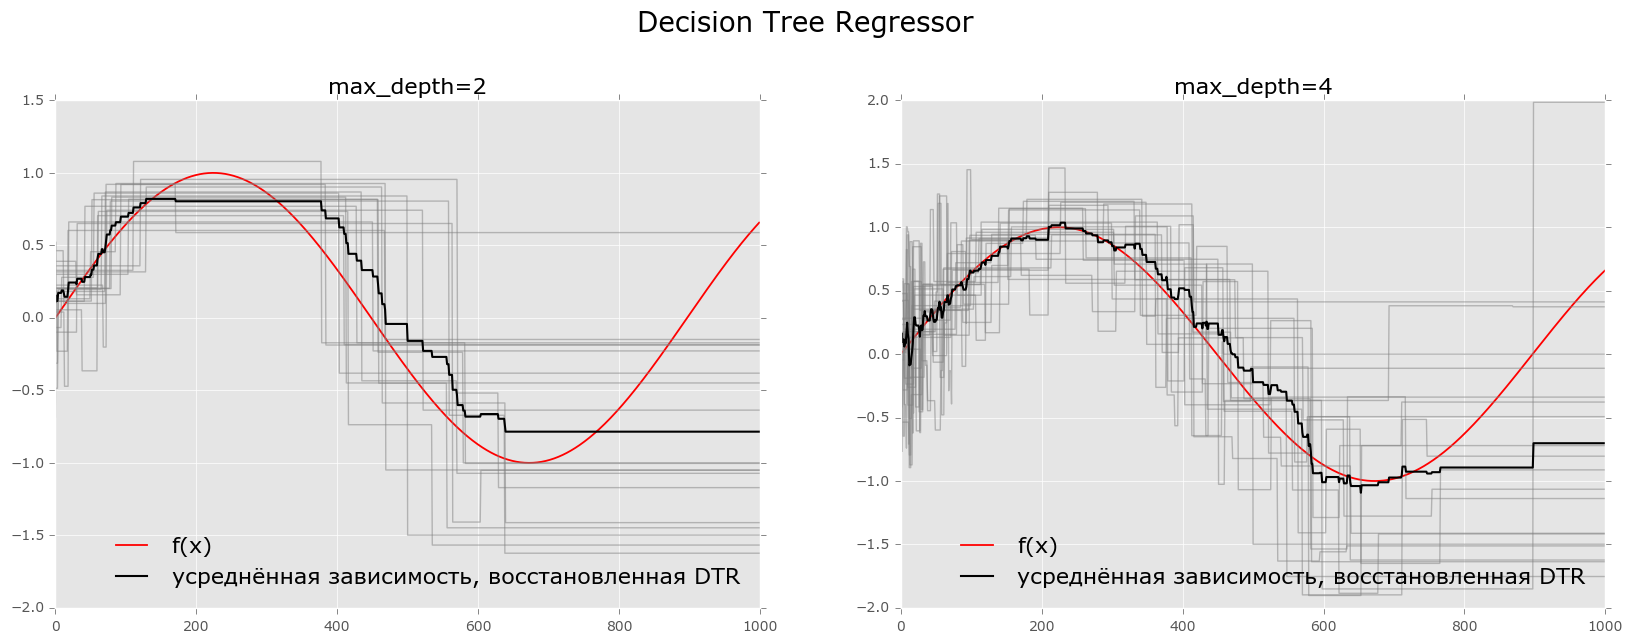

In [9]:
plt.figure(figsize=(20, 7))
plt.subplots_adjust(top=.85)
plt.suptitle('Decision Tree Regressor', fontsize=20)

plt.subplot(1, 2, 1)
p11, = plt.plot(f(linspace), c='red', lw=1.3)

plt.subplot(1, 2, 2)
p12, = plt.plot(f(linspace), c='red', lw=1.3)

predict_s2 = []
predict_s4 = []
for i in range(samples_num):
    x = np.random.exponential(size = sample_size)
    noise = np.random.uniform(-1, 1, size = sample_size)
    y = f(x) + noise
    
    plt.subplot(1, 2, 1)
    DTR = DecisionTreeRegressor(max_depth=2)
    DTR.fit(x.reshape(-1, 1), y)
    predict = DTR.predict(linspace.reshape(-1, 1))
    plt.plot(predict, color='grey', alpha=0.5)
    predict_s2.append(predict)
    
    plt.subplot(1, 2, 2)
    DTR = DecisionTreeRegressor(max_depth=4)
    DTR.fit(x.reshape(-1, 1), y)
    predict = DTR.predict(linspace.reshape(-1, 1))
    plt.plot(predict, color='grey', alpha=0.5)
    predict_s4.append(predict)
    
plt.subplot(1, 2, 1)
p21, = plt.plot(np.mean(np.array(predict_s2), axis=0), c='black', lw=1.5)
plt.legend([p11, p21], ['f(x)', 'усреднённая зависимость, восстановленная DTR'], 
           loc=4, fancybox=True, framealpha=0, fontsize=16)
plt.title('max_depth=2', fontsize=16)

plt.subplot(1, 2, 2)
p22, = plt.plot(np.mean(np.array(predict_s4), axis=0), c='black', lw=1.5)
plt.legend([p12, p22], ['f(x)', 'усреднённая зависимость, восстановленная DTR'], 
           loc=4, fancybox=True, framealpha=0, fontsize=16)
plt.title('max_depth=4', fontsize=16)

plt.show()

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

**Insight:** Чем выше глубина дерева, тем меньше смещение решающих деревьев и тем выше их разброс, что подтверждают результаты эксперимента. В первом случае, без ограничения на глубину, смещение было самым минимальным при очень высоком разбросе; во втором, при сильном ограничении на глубину, - был самый минимальный разброс, однако наблюдается сильное смещение. В третьем случае наблюдается оптимальный трейд-офф между смещением и разбросом.

__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn import svm

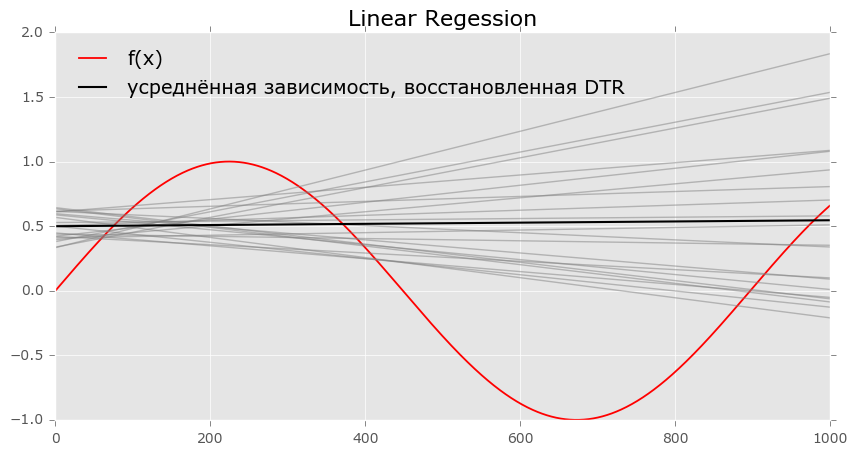

In [11]:
plt.figure(figsize=(10, 5))
p1, = plt.plot(f(linspace), c='red', lw=1.3)

LR = LinearRegression()
predict_s = []
for i in range(samples_num):
    x = np.random.exponential(size = sample_size)
    noise = np.random.uniform(-1, 1, size = sample_size)
    y = f(x) + noise   
    LR.fit(x.reshape(-1, 1), y)
    predict = LR.predict(linspace.reshape(-1, 1))
    plt.plot(predict, color='grey', alpha=0.5)
    predict_s.append(predict)
    
p2, = plt.plot(np.mean(np.array(predict_s), axis=0), c='black', lw=1.5)
plt.legend([p1, p2], ['f(x)', 'усреднённая зависимость, восстановленная DTR'],
           loc='best', fancybox=True, framealpha=0, fontsize=14)
plt.title('Linear Regession', fontsize=16)
plt.show()

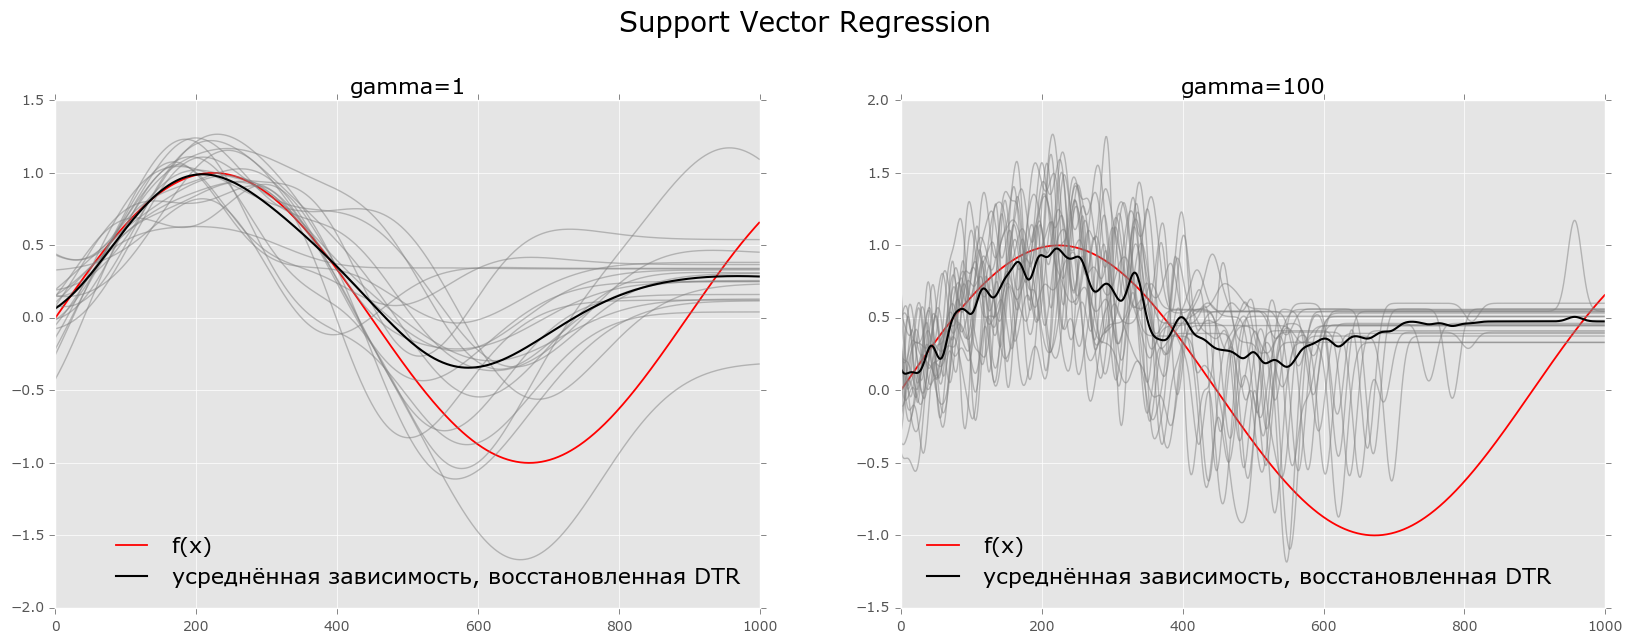

In [12]:
plt.figure(figsize=(20, 7))
plt.subplots_adjust(top=.85)
plt.suptitle('Support Vector Regression', fontsize=20)

plt.subplot(1, 2, 1)
p11, = plt.plot(f(linspace), c='red', lw=1.3)

plt.subplot(1, 2, 2)
p12, = plt.plot(f(linspace), c='red', lw=1.3)

predict_s1 = []
predict_s100 = []
for i in range(samples_num):
    x = np.random.exponential(size = sample_size)
    noise = np.random.uniform(-1, 1, size = sample_size)
    y = f(x) + noise
    
    plt.subplot(1, 2, 1)
    SVR = svm.SVR(kernel='rbf', gamma=1)
    SVR.fit(x.reshape(-1, 1), y)
    predict = SVR.predict(linspace.reshape(-1, 1))
    plt.plot(predict, color='grey', alpha=0.5)
    predict_s1.append(predict)
    
    plt.subplot(1, 2, 2)
    SVR = svm.SVR(kernel='rbf', gamma=100)
    SVR.fit(x.reshape(-1, 1), y)
    predict = SVR.predict(linspace.reshape(-1, 1))
    plt.plot(predict, color='grey', alpha=0.5)
    predict_s100.append(predict)
    
plt.subplot(1, 2, 1)
p21, = plt.plot(np.mean(np.array(predict_s1), axis=0), c='black', lw=1.5)
plt.legend([p11, p21], ['f(x)', 'усреднённая зависимость, восстановленная DTR'], 
           loc=4, fancybox=True, framealpha=0, fontsize=16)
plt.title('gamma=1', fontsize=16)

plt.subplot(1, 2, 2)
p22, = plt.plot(np.mean(np.array(predict_s100), axis=0), c='black', lw=1.5)
plt.legend([p12, p22], ['f(x)', 'усреднённая зависимость, восстановленная DTR'], 
           loc='best', fancybox=True, framealpha=0, fontsize=16)
plt.title('gamma=100', fontsize=16)

plt.show()

**Insight:** Линейная регрессия, очевидно, плохо справилась с задачей, так как предсказывать синусоиду с большой амплитудой с помощью прямой линии - наверное, не самая хорошая идея. Касательно SVR стоит заметить, что регрессия с параметром $\gamma = 1$ проявила себя лучше: на левом графике мы видим меньшее смещение и отсутствие разброса, если сравнивать с правым. Таким образом, данный эксперимент учит правильному подбору параметров при рассмотрении разных зависимостей: увеличение $\gamma$, которая отвечает за изгиб (сложность зависимости), не приведет к улучшению качества, если перед нами простая зависимость, но и линейная регрессия не спасет, если эта зависимость "сложнее" прямой линии.

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [13]:
import pandas as pd

In [14]:
m = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', 
                   header = None)
t = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data', 
                   header = None)
c = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', 
                   header = None)
n = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', 
                   header = None)

In [15]:
df_m = m.copy()
df_t = t.copy()
df_c = c.copy()
df_n = n.copy()

In [16]:
df_m[:2]

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g


In [17]:
df_t[:2]

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive


In [18]:
df_c[:2]

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc


In [19]:
df_c[6][(df_c[6] == 'unacc') | (df_c[6] == 'acc')] = 0
df_c[6][(df_c[6] == 'vgood') | (df_c[6] == 'good')] = 1

In [20]:
df_n[:2]

,0,1,2,3,4,5,6,7,8
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority


In [21]:
df_n[8][(df_n[8] == 'not_recom') | (df_n[8] == 'recommend')] = 0
df_n[8][(df_n[8] == 'very_recom') | (df_n[8] == 'spec_prior') | (df_n[8] == 'priority')] = 1

Преобразуем все признаки в **вещественные** с помощью LabelEncoder (LE).

In [22]:
from sklearn.preprocessing import LabelEncoder

In [23]:
LE = LabelEncoder()

for col in df_m:
    df_m[col] = LE.fit(df_m[col]).transform(df_m[col])
for col in df_t:
    df_t[col] = LE.fit(df_t[col]).transform(df_t[col])
for col in df_c:
    df_c[col] = LE.fit(df_c[col]).transform(df_c[col])
for col in df_n:
    df_n[col] = LE.fit(df_n[col]).transform(df_n[col])

In [24]:
y_m = df_m[0]
y_t = df_t[9]
y_c = df_c[6]
y_n = df_n[8]

del df_m[0]
del df_t[9]
del df_c[6]
del df_n[8]

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In [26]:
DTR = DecisionTreeClassifier(random_state=42)
print('\n mushrooms \n', 
     cross_val_score(DTR, df_m, y_m, cv=10, scoring=make_scorer(accuracy_score)), 
      '\n \n tic-rac-toe \n', 
     cross_val_score(DTR, df_t, y_t, cv=10, scoring=make_scorer(accuracy_score)),
      '\n \n cars \n', 
     cross_val_score(DTR, df_c, y_c, cv=10, scoring=make_scorer(accuracy_score)),
      '\n \n nursery \n', 
     cross_val_score(DTR, df_n, y_n, cv=10, scoring=make_scorer(accuracy_score)))


 mushrooms 
 [ 0.68511685  1.          1.          1.          1.          1.          1.
  1.          0.93341554  1.        ] 
 
 tic-rac-toe 
 [ 0.70103093  0.71134021  0.48958333  0.8125      0.54166667  0.70833333
  0.85263158  0.85263158  0.92631579  0.88421053] 
 
 cars 
 [ 0.91954023  0.94827586  0.92528736  0.97126437  0.97093023  0.98837209
  0.91860465  0.87790698  0.93023256  0.95348837] 
 
 nursery 
 [ 0.99845798  1.          0.99845679  1.          1.          1.          1.
  1.          1.          1.        ]


Преобразуем все признаки в **категориальные** (в дамми) с помощью One-Hot-Encoding (OHE).

In [27]:
df_m = m.copy()
df_t = t.copy()
df_c = c.copy()
df_n = n.copy()

df_m[0][(df_m[0] == 'e')] = 0
df_m[0][(df_m[0] == 'p')] = 1

df_t[9][(df_t[9] == 'negative')] = 0
df_t[9][(df_t[9] == 'positive')] = 1

df_c[6][(df_c[6] == 'unacc') | (df_c[6] == 'acc')] = 0
df_c[6][(df_c[6] == 'vgood') | (df_c[6] == 'good')] = 1

df_n[8][(df_n[8] == 'not_recom') | (df_n[8] == 'recommend')] = 0
df_n[8][(df_n[8] == 'very_recom') | (df_n[8] == 'spec_prior') | (df_n[8] == 'priority')] = 1

y_m = df_m[0]
y_t = df_t[9]
y_c = df_c[6]
y_n = df_n[8]

del df_m[0]
del df_t[9]
del df_c[6]
del df_n[8]

In [28]:
df_m = pd.concat([pd.get_dummies(df_m[1], prefix='cap-shape'),
                  pd.get_dummies(df_m[2], prefix='cap-surface'),
                  pd.get_dummies(df_m[3], prefix='cap-color'),
                  pd.get_dummies(df_m[4], prefix='bruises'),
                  pd.get_dummies(df_m[5], prefix='odor'),
                  pd.get_dummies(df_m[6], prefix='gill-attachment'),
                  pd.get_dummies(df_m[7], prefix='gill-spacing'),
                  pd.get_dummies(df_m[8], prefix='gill-size'),
                  pd.get_dummies(df_m[9], prefix='gill-color'),
                  pd.get_dummies(df_m[10], prefix='stalk-shape'),
                  pd.get_dummies(df_m[11], prefix='stalk-root'),
                  pd.get_dummies(df_m[12], prefix='stalk-surface-above-ring'),
                  pd.get_dummies(df_m[13], prefix='stalk-surface-below-ring'),
                  pd.get_dummies(df_m[14], prefix='stalk-color-above-ring'),
                  pd.get_dummies(df_m[15], prefix='stalk-color-below-ring'),
                  pd.get_dummies(df_m[16], prefix='veil-type'),
                  pd.get_dummies(df_m[17], prefix='veil-color'),
                  pd.get_dummies(df_m[18], prefix='ring-number'),
                  pd.get_dummies(df_m[19], prefix='ring-type'),
                  pd.get_dummies(df_m[20], prefix='spore-print-color'),
                  pd.get_dummies(df_m[21], prefix='population'),
                  pd.get_dummies(df_m[22], prefix='habitat')

    ], axis=1)

In [29]:
df_t = pd.concat([pd.get_dummies(df_t[0], prefix='top-left-square'),
                  pd.get_dummies(df_t[1], prefix='top-middle-square'),
                  pd.get_dummies(df_t[2], prefix='top-right-square'),
                  pd.get_dummies(df_t[3], prefix='middle-left-square'),
                  pd.get_dummies(df_t[4], prefix='middle-middle-square'),
                  pd.get_dummies(df_t[5], prefix='middle-right-square'),
                  pd.get_dummies(df_t[6], prefix='bottom-left-square'),
                  pd.get_dummies(df_t[7], prefix='bottom-middle-square'),
                  pd.get_dummies(df_t[8], prefix='bottom-right-square')

    ], axis=1)

In [30]:
df_c = pd.concat([pd.get_dummies(df_c[0], prefix='buying'),
                  pd.get_dummies(df_c[1], prefix='maint'),
                  pd.get_dummies(df_c[2], prefix='doors'),
                  pd.get_dummies(df_c[3], prefix='persons'),
                  pd.get_dummies(df_c[4], prefix='lug_boot'),
                  pd.get_dummies(df_c[5], prefix='safety')

    ], axis=1)

In [31]:
df_n = pd.concat([pd.get_dummies(df_n[0], prefix='parents'),
                  pd.get_dummies(df_n[1], prefix='has_nurs'),
                  pd.get_dummies(df_n[2], prefix='form'),
                  pd.get_dummies(df_n[3], prefix='children'),
                  pd.get_dummies(df_n[4], prefix='housing'),
                  pd.get_dummies(df_n[5], prefix='finance'),
                  pd.get_dummies(df_n[6], prefix='social'),
                  pd.get_dummies(df_n[7], prefix='health')

    ], axis=1)

In [32]:
DTR = DecisionTreeClassifier(random_state=42)
print('\n mushrooms \n', 
     cross_val_score(DTR, df_m.astype(int), y_m.astype(int), cv=10, scoring=make_scorer(accuracy_score)), 
      '\n \n tic-rac-toe \n', 
     cross_val_score(DTR, df_t.astype(int), y_t.astype(int), cv=10, scoring=make_scorer(accuracy_score)),
      '\n \n cars \n', 
     cross_val_score(DTR, df_c.astype(int), y_c.astype(int), cv=10, scoring=make_scorer(accuracy_score)),
      '\n \n nursery \n', 
     cross_val_score(DTR, df_n.astype(int), y_n.astype(int), cv=10, scoring=make_scorer(accuracy_score)))


 mushrooms 
 [ 0.68511685  1.          1.          1.          0.99753998  1.          1.
  1.          0.88162762  1.        ] 
 
 tic-rac-toe 
 [ 0.69072165  0.88659794  0.42708333  0.92708333  0.90625     0.76041667
  0.93684211  0.77894737  0.95789474  0.84210526] 
 
 cars 
 [ 0.91954023  0.95977011  0.98850575  0.97126437  0.86046512  0.99418605
  0.89534884  0.5755814   0.98255814  0.1627907 ] 
 
 nursery 
 [ 0.99845798  1.          1.          1.          1.          1.          1.
  1.          1.          1.        ]


Сделаем **корректное разбиение**. Согласно комментариям в чате telegram подразумевается следующая предобработка данных:
* три признака, которые похожи на вещественные, но имеют категорию more - оставляем такими же, меняем more на число;
* категориальные признаки, в которых категории могут быть расположены по порядку, преобразовываем в вещественные с помощью LE;
* остальные категориальные признаки преобразовываем в дамми с помощью OHE.

_Важно!_ Все признаки в первых двух дата-сетах являются неупорядоченными категориальными, поэтому "корректное разбиение" можно выполнить только на двух остальных (cars and nursery)

In [33]:
df_c = c.copy()
df_n = n.copy()

df_c[6][(df_c[6] == 'unacc') | (df_c[6] == 'acc')] = 0
df_c[6][(df_c[6] == 'vgood') | (df_c[6] == 'good')] = 1

df_n[8][(df_n[8] == 'not_recom') | (df_n[8] == 'recommend')] = 0
df_n[8][(df_n[8] == 'very_recom') | (df_n[8] == 'spec_prior') | (df_n[8] == 'priority')] = 1

y_c = df_c[6]
y_n = df_n[8]

del df_c[6]
del df_n[8]

In [34]:
#CARS

#оставляем как вещественные с заменой
df_c[2][(df_c[2] == '5more')] = 5 #doors
df_c[3][(df_c[3] == 'more')] = 7   #persons

#все остальные признаки упорядочены, поэтому преобразуем в вещественные
#так как важен порядок, попробуем не использовать LE

#buying
df_c[0][(df_c[0] == 'low')] = 1
df_c[0][(df_c[0] == 'med')] = 2
df_c[0][(df_c[0] == 'high')] = 3
df_c[0][(df_c[0] == 'vhigh')] = 4

#maint
df_c[1][(df_c[1] == 'low')] = 1
df_c[1][(df_c[1] == 'med')] = 2
df_c[1][(df_c[1] == 'high')] = 3
df_c[1][(df_c[1] == 'vhigh')] = 4

#lug_boot
df_c[4][(df_c[4] == 'small')] = 1
df_c[4][(df_c[4] == 'med')] = 2
df_c[4][(df_c[4] == 'big')] = 3

#safety
df_c[5][(df_c[5] == 'low')] = 1
df_c[5][(df_c[5] == 'med')] = 2
df_c[5][(df_c[5] == 'high')] = 3

In [35]:
#NURSERY

#оставляем как вещественные с заменой
df_n[3][(df_n[3] == 'more')] = 5 #children

#упорядоченные признаки преобразуем в вещественные
#так как важен порядок, попробуем не использовать LE

#parents
df_n[0][(df_n[0] == 'usual')] = 1
df_n[0][(df_n[0] == 'pretentious')] = 2
df_n[0][(df_n[0] == 'great_pret')] = 3

#has_nurs
df_n[1][(df_n[1] == 'very_crit')] = 1
df_n[1][(df_n[1] == 'critical')] = 2
df_n[1][(df_n[1] == 'improper')] = 3
df_n[1][(df_n[1] == 'less_proper')] = 4
df_n[1][(df_n[1] == 'proper')] = 5

#housing
df_n[4][(df_n[4] == 'critical')] = 1
df_n[4][(df_n[4] == 'less_conv')] = 2
df_n[4][(df_n[4] == 'convenient')] = 3

#finance
df_n[5][(df_n[5] == 'inconv')] = 1
df_n[5][(df_n[5] == 'convenient')] = 2

#social
df_n[6][(df_n[6] == 'problematic')] = 1
df_n[6][(df_n[6] == 'slightly_prob')] = 2
df_n[6][(df_n[6] == 'nonprob')] = 3

#health
df_n[7][(df_n[7] == 'not_recom')] = 1
df_n[7][(df_n[7] == 'priority')] = 2
df_n[7][(df_n[7] == 'recommended')] = 3

#признак form {complete, completed, incomplete, foster} оставим в качестве неупорядоченного категориального
df_n = pd.concat([df_n[0],
                  df_n[1],
                  pd.get_dummies(df_n[2], prefix='form'),
                  df_n[3],
                  df_n[4],
                  df_n[5],
                  df_n[6],
                  df_n[7]

    ], axis=1)

In [36]:
DTR = DecisionTreeClassifier(random_state=42)
print('\n cars \n', 
     cross_val_score(DTR, df_c.astype(int), y_c.astype(int), cv=10, scoring=make_scorer(accuracy_score)),
      '\n \n nursery \n', 
     cross_val_score(DTR, df_n.astype(int), y_n.astype(int), cv=10, scoring=make_scorer(accuracy_score)))


 cars 
 [ 0.91954023  0.94827586  0.98850575  0.97126437  0.97093023  0.98837209
  0.91860465  0.90697674  0.98255814  0.1627907 ] 
 
 nursery 
 [ 0.99845798  1.          1.          0.99845679  1.          1.          1.
  1.          1.          1.        ]


__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Insight:** <br\> <br\>
Среднее значение accuracy_score
* mushrooms (#1)
    * все вещественные 0.96185 (1st place)
    * все категориальные 0.95643 (2nd place)
* tic-rac-toe (#2)
    * все вещественные 0.74802 (2nd place)
    * все категориальные 0.81139 (1st place)
* cars (#3)
    * все вещественные 0.94039 (1st place)
    * все категориальные 0.83100 (3d place)
    * "корректное" разбиение 0.87578 (2nd place)
* nursery (#4)
    * все вещественные 0.99969
    * все категориальные 0.99985 (1st place)
    * "корректное" разбиение 0.99969 <br\>
    
Результаты эксперимента неоднозначные, но на мой взгляд, объяснимые. Для первого датасета вариант OHE оказался не выигрышным, так как получилось размывание признаков (22 признака по несколько категорий в каждом). Для второго же датасета наоборот, OHE значительно лучше LE (признаков не так много, при этом важная какая-то особая комбинация (например, ход крестиком в центр), которая как раз может быть задана через OHE). Для дата-сета cars лучшим оказался LE, поскольку категории были упорядочены и пронормализованы алгоритмом. Для nursery - ручная настройка и LE сработали одинаково хорошо, но всё же чуть хуже OHE. В данном случае, OHE, вероятно, опять же сработал лучше из-за какого-то набора комбинаций, а два остальных алгоритма сработали одинаково, видимо, из-за отсутствия необходимости в сильной нормализации.<br\><br\>
Таким образом, главные выводы данного упражнения:
* результаты прогнозирования зависят от качества предобработки данных
* при выборе инструмента для предобработки необходимо ориентироваться на данные, а именно на признаки объектов и их количество, тип признаков и количество значений каждого <br\>

Как мне кажется, на результаты эксперимента (в 3 и 4 дата-сетах) повлияла частота встречаемости того или иного значения в признаке (аналогично проблеме невзвешенности классов), о чем свидетельствует расхождение результатов по LE и ручной обработке. Так как LE включает в себя нормализацию, то он самостоятельно справляется с данной проблемой.

Для улучшения качества моделей при предобработке с помощью OHE можно использовать различные способы, сокращающие размерность (выбрасываение случайно выбранных преобразованных признаков, хэширование).

### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [37]:
df_wr = pd.read_csv('winequality-red.csv', sep = ';')
df_wr.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [38]:
y = df_wr['quality']
del df_wr['quality']

In [39]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [40]:
len(df_wr.keys())

11

In [41]:
print('\n DecisionTreeClassifier \n', 
     cross_val_score(DecisionTreeClassifier(random_state=42), 
                     df_wr, y, cv=3, scoring=make_scorer(accuracy_score)).mean(), 
      '\n \n BaggingClassifier, n_estimators=100 \n', 
     cross_val_score(BaggingClassifier(n_estimators=100, random_state=42), 
                     df_wr, y, cv=3, scoring=make_scorer(accuracy_score)).mean(),
      '\n \n BaggingClassifier, n_estimators=100,  max_features=6 \n', 
     cross_val_score(BaggingClassifier(n_estimators=100, max_features=6,random_state=42), 
                     df_wr, y, cv=3, scoring=make_scorer(accuracy_score)).mean(),
      '\n \n RandomForestClassifier, n_estimators=100 \n', 
     cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), 
                     df_wr, y, cv=3, scoring=make_scorer(accuracy_score)).mean())


 DecisionTreeClassifier 
 0.452820158171 
 
 BaggingClassifier, n_estimators=100 
 0.57104114795 
 
 BaggingClassifier, n_estimators=100,  max_features=6 
 0.552291023363 
 
 RandomForestClassifier, n_estimators=100 
 0.559184456052


#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [42]:
from sklearn.utils import shuffle

df_wr = pd.read_csv('winequality-red.csv', sep = ';')
df_wr = shuffle(df_wr, random_state=42)

y = df_wr['quality']
del df_wr['quality']

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_wr, y, test_size=0.3, random_state=42)

In [44]:
RFC = RandomForestClassifier(warm_start=True, random_state=666)
scores = []
for i in range(100, 5001, 100):
    RFC.set_params(n_estimators=i)
    RFC.fit(X_train, y_train)
    scores.append(accuracy_score(y_test, RFC.predict(X_test)))

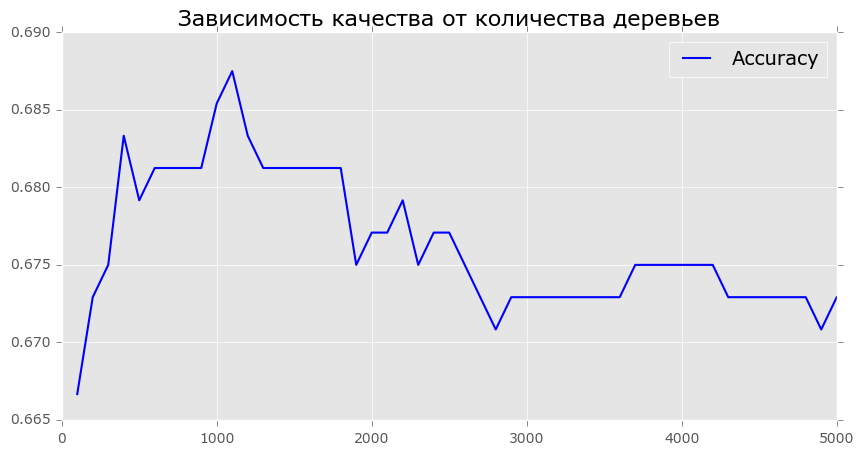

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(range(100, 5001, 100), scores, c='blue', lw=1.5)
plt.legend(['Accuracy'], fontsize=14)
plt.title('Зависимость качества от количества деревьев', fontsize=16)
plt.show()

In [46]:
print('\n Самое высокое значение метрики достигается при n_estimators=%1.f.' 
      %(range(100, 5001, 100)[scores.index(max(scores))])
      + '\n Далее с ростом количества деревьев наблюдается резкое снижение качества предсказаний,'
      + '\n что свидетельствует об эффекте переобучения.' )


 Самое высокое значение метрики достигается при n_estimators=1100.
 Далее с ростом количества деревьев наблюдается резкое снижение качества предсказаний,
 что свидетельствует об эффекте переобучения.


### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

**ATTENTION** <br\>
При выполнении данного задания использовался код с [Fuyang Liu's Blog](http://liufuyang.github.io/2017/04/01/just-another-tensorflow-beginner-guide-3.html).

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

In [47]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

In [48]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

In [49]:
batch_size = 128
num_classes = 10
epochs = 10

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [50]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(784,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 52us/step - loss: 0.3266 - acc: 0.9077 - val_loss: 0.1718 - val_acc: 0.9474
Epoch 2/10
60000/60000 [==============================] - 3s 46us/step - loss: 0.1410 - acc: 0.9583 - val_loss: 0.1202 - val_acc: 0.9628
Epoch 3/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.0980 - acc: 0.9709 - val_loss: 0.0965 - val_acc: 0.9694
Epoch 4/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.0747 - acc: 0.9773 - val_loss: 0.0907 - val_acc: 0.9724
Epoch 5/10
60000/60000 [==============================] - 3s 48us/step - loss: 0.0611 - acc: 0.9812 - val_loss: 0.0908 - val_acc: 0.9715
Epoch 6/10
60000/60000 [==============================] - 3s 49us/step - loss: 0.0504 - acc: 0.9847 - val_loss: 0.0791 - val_acc: 0.9773
Epoch 7/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.0423 - acc: 0.9868 - val_loss: 0.0758 - val_acc

**Insight:** качество на тесте (accuracy) = 0,9759

__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

In [52]:
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist

In [53]:
np.random.seed(398)
tf.set_random_seed(398)

In [54]:
batch_size = 128

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [55]:
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

model = Sequential()

model.add(Convolution2D(32, (6, 6), activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 23, 23, 32)        1184      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          36896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               36992     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total para

In [56]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

model.fit(X_train, Y_train,
          batch_size=batch_size, epochs=5, verbose=1,
          validation_data=(X_test, Y_test))

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 75s 1ms/step - loss: 0.2254 - acc: 0.9303 - val_loss: 0.0720 - val_acc: 0.9760
Epoch 2/5
60000/60000 [==============================] - 70s 1ms/step - loss: 0.0582 - acc: 0.9815 - val_loss: 0.0429 - val_acc: 0.9859
Epoch 3/5
60000/60000 [==============================] - 74s 1ms/step - loss: 0.0395 - acc: 0.9883 - val_loss: 0.0315 - val_acc: 0.9893
Epoch 4/5
60000/60000 [==============================] - 76s 1ms/step - loss: 0.0303 - acc: 0.9908 - val_loss: 0.0295 - val_acc: 0.9891
Epoch 5/5
60000/60000 [==============================] - 74s 1ms/step - loss: 0.0245 - acc: 0.9923 - val_loss: 0.0251 - val_acc: 0.9915
Test loss: 0.0251176651836
Test accuracy: 0.9915


**Insight:** Рекомендации по настройке модели помогли достигнуть качества на тесте (accuracy) = 0,9915 (против 0,9759 в предыдущем варианте исполнения). При этом на само обучение было затрачено 6-7 минут, что (по опыту) очень неплохо.

__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

In [57]:
model = Sequential()

model.add(Convolution2D(32, (6, 6), activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 23, 23, 32)        1184      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 32)          36896     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               36992     
__________

In [58]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

model.fit(X_train, Y_train,
          batch_size=batch_size, epochs=5, verbose=1,
          validation_data=(X_test, Y_test))

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 77s 1ms/step - loss: 0.3165 - acc: 0.8996 - val_loss: 0.0608 - val_acc: 0.9816
Epoch 2/5
60000/60000 [==============================] - 78s 1ms/step - loss: 0.0911 - acc: 0.9718 - val_loss: 0.0447 - val_acc: 0.9846
Epoch 3/5
60000/60000 [==============================] - 76s 1ms/step - loss: 0.0632 - acc: 0.9804 - val_loss: 0.0310 - val_acc: 0.9897
Epoch 4/5
60000/60000 [==============================] - 74s 1ms/step - loss: 0.0520 - acc: 0.9841 - val_loss: 0.0305 - val_acc: 0.9901
Epoch 5/5
60000/60000 [==============================] - 76s 1ms/step - loss: 0.0444 - acc: 0.9861 - val_loss: 0.0250 - val_acc: 0.9917
Test loss: 0.0250440051152
Test accuracy: 0.9917


**Insight:** Включение слоёв Dropout позволило увеличить качество на 0,0002 (что, мне кажется, достаточно много в случае, когда accuracy уже 0,99) и снизить в среднем ошибку (test loss). Это объясняется тем, что Dropout слои рандомно выкидывают заданный процент нейронов на том этапе сети, где установлены. Такой метод позволяет избегать переобучения сети, что продемонстрировал данный эксперимент.